In [1]:
!pip install 'vanna[chromadb,mysql]' dashscope -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [2]:
from vanna.base import VannaBase
from vanna.chromadb import ChromaDB_VectorStore
from dashscope import Generation

# 自定义LLM

https://vanna.ai/docs/mysql-other-llm-chromadb/

In [3]:
import random 

DEBUG_INFO=None

class QwenLLM(VannaBase):
  def __init__(self,config=None):
    self.model=config['model']
    self.api_key=config['api_key']
  
  def system_message(self,message: str):
    return {'role':'system','content':message}

  def user_message(self, message: str):
    return {'role':'user','content':message}

  def assistant_message(self, message: str):
    return {'role':'assistant','content':message}
  
  def submit_prompt(self,prompt,**kwargs):
    resp=Generation.call(
      model=self.model,
      messages=prompt,
      seed=random.randint(1, 10000),
      result_format='message',
      api_key=self.api_key)
    answer=resp.output.choices[0].message.content
    global DEBUG_INFO
    DEBUG_INFO=(prompt,answer)
    return answer

# Vanna客户端

In [4]:
class MyVanna(ChromaDB_VectorStore,QwenLLM):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self,config=config)
        QwenLLM.__init__(self,config=config)

In [5]:
vn=MyVanna({'api_key':'填写你的阿里云dashscope秘钥','model':'qwen-max'})

# MySQL服务端

sudo docker run -d --name mysql-vanna -p 3306:3306 -e MYSQL_ROOT_PASSWORD=123456 mysql:8

mysql --protocol=tcp -hlocalhost -P3306 -uroot -p123456

CREATE TABLE IF NOT EXISTS user (
        id INT PRIMARY KEY COMMENT '用户ID' ,
        name VARCHAR(100) COMMENT '姓名',
        age INT COMMENT '年龄'
    ) COMMENT '用户信息表';
    
insert into user values(1,'小鱼儿',34),(2,'小悲剧',36);

# 构造向量库

In [6]:
vn.connect_to_mysql(host='localhost',dbname='demo',user='root',password='123456',port=3306)

In [7]:
DDL='''CREATE TABLE IF NOT EXISTS user (
        id INT PRIMARY KEY COMMENT '用户ID' ,
        name VARCHAR(100) COMMENT '姓名',
        age INT COMMENT '年龄'
    ) COMMENT '用户信息表';
'''

In [8]:
# 存储DDL到向量库
vn.train(ddl=DDL)

Add of existing embedding ID: ab0ac208-2f5e-50b0-9177-423427220940-ddl
Add of existing embedding ID: ab0ac208-2f5e-50b0-9177-423427220940-ddl
Add of existing embedding ID: ab0ac208-2f5e-50b0-9177-423427220940-ddl
Add of existing embedding ID: ab0ac208-2f5e-50b0-9177-423427220940-ddl
Add of existing embedding ID: ab0ac208-2f5e-50b0-9177-423427220940-ddl
Insert of existing embedding ID: ab0ac208-2f5e-50b0-9177-423427220940-ddl


Adding ddl: CREATE TABLE IF NOT EXISTS user (
        id INT PRIMARY KEY COMMENT '用户ID' ,
        name VARCHAR(100) COMMENT '姓名',
        age INT COMMENT '年龄'
    ) COMMENT '用户信息表';



'ab0ac208-2f5e-50b0-9177-423427220940-ddl'

In [9]:
# 存储document到向量库
vn.train(documentation='"福报"是指age>=35岁，也就是可以向社会输送的人才')

Adding documentation....


Add of existing embedding ID: 8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc
Add of existing embedding ID: 8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc
Add of existing embedding ID: 8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc
Add of existing embedding ID: 8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc
Insert of existing embedding ID: 8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc
Add of existing embedding ID: 8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc


'8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc'

In [10]:
# 存储SQL到向量库
'''
1，通过LLM根据SQL构造一个question
2，按question-SQL的JSON入库
            {
                "question": question,
                "sql": sql,
            }
'''

vn.train(sql='select name from user where age between 10 and 20')

Add of existing embedding ID: 9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql
Add of existing embedding ID: e5102160-2dbf-5300-98f5-24d762a12b59-sql
Add of existing embedding ID: 9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql
Add of existing embedding ID: e5102160-2dbf-5300-98f5-24d762a12b59-sql
Add of existing embedding ID: eb6bbff7-a89c-51bc-a58d-ebf6dc181ae3-sql
Add of existing embedding ID: 9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql
Add of existing embedding ID: e5102160-2dbf-5300-98f5-24d762a12b59-sql
Add of existing embedding ID: eb6bbff7-a89c-51bc-a58d-ebf6dc181ae3-sql
Add of existing embedding ID: 9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql
Add of existing embedding ID: e5102160-2dbf-5300-98f5-24d762a12b59-sql
Add of existing embedding ID: eb6bbff7-a89c-51bc-a58d-ebf6dc181ae3-sql
Add of existing embedding ID: 54db6ffd-201b-59a2-8568-cd05d82db461-sql
Insert of existing embedding ID: 9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql
Add of existing embedding ID: 9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql


Question generated with sql: What are the names of users whose age is between 10 and 20? 
Adding SQL...


'9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql'

In [11]:
Q,A=DEBUG_INFO
print('PROMPT:',Q[0]['content'])
print('ANSWER:',A)

PROMPT: The user will give you SQL and you will try to guess what the business question this query is answering. Return just the question without any additional explanation. Do not reference the table name in the question.
ANSWER: What are the names of users whose age is between 10 and 20?


In [12]:
# 存储question-SQL到向量库
'''
按question-SQL的JSON入库
            {
                "question": question,
                "sql": sql,
            }
'''
vn.train(question='小鱼儿的年龄',sql='select age from user where name="小鱼儿"')

Insert of existing embedding ID: e5102160-2dbf-5300-98f5-24d762a12b59-sql
Add of existing embedding ID: e5102160-2dbf-5300-98f5-24d762a12b59-sql


'e5102160-2dbf-5300-98f5-24d762a12b59-sql'

In [13]:
# 检查所有入库的知识
vn.get_training_data()

,id,question,content,training_data_type
0,54db6ffd-201b-59a2-8568-cd05d82db461-sql,打算给一批员工送福报，把他们的名字过滤出来,select name from user where age >= 35,sql
1,9ccf7bcd-5091-5b97-bf72-af9d41e526a5-sql,What are the names of users whose age is betwe...,select name from user where age between 10 and 20,sql
2,e5102160-2dbf-5300-98f5-24d762a12b59-sql,小鱼儿的年龄,"select age from user where name=""小鱼儿""",sql
3,eb6bbff7-a89c-51bc-a58d-ebf6dc181ae3-sql,用户的平均年龄,select avg(age) from user,sql
0,ab0ac208-2f5e-50b0-9177-423427220940-ddl,None,CREATE TABLE IF NOT EXISTS user (\n id ...,ddl
0,8fc54ebe-8bb3-5fb7-88a6-5c98d817ed07-doc,None,"""福报""是指age>=35岁，也就是可以向社会输送的人才",documentation


# 开始查询

In [14]:
# 基本使用
result=vn.generate_sql('用户的平均年龄')
print('SQL:',result)

Q,A=DEBUG_INFO
print('PROMPT:',Q[0]['content'])
print('ANSWER:',A)

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


[{'role': 'system', 'content': 'You are a SQL expert. \n===Tables \nCREATE TABLE IF NOT EXISTS user (\n        id INT PRIMARY KEY COMMENT \'用户ID\' ,\n        name VARCHAR(100) COMMENT \'姓名\',\n        age INT COMMENT \'年龄\'\n    ) COMMENT \'用户信息表\';\n\n\n\n===Additional Context \n\n"福报"是指age>=35岁，也就是可以向社会输送的人才\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n3. If the provided context is insufficient, please explain why it can\'t be generated. \n4. Please use the most relevant table(s). \n5. If the question has been asked and answered before, please repeat the answer exactly as it was given before. \n'}, {'role': 'user', 'content'

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


[{'role': 'system', 'content': 'You are a SQL expert. \n===Tables \nCREATE TABLE IF NOT EXISTS user (\n        id INT PRIMARY KEY COMMENT \'用户ID\' ,\n        name VARCHAR(100) COMMENT \'姓名\',\n        age INT COMMENT \'年龄\'\n    ) COMMENT \'用户信息表\';\n\n\n\n===Additional Context \n\n"福报"是指age>=35岁，也就是可以向社会输送的人才\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n3. If the provided context is insufficient, please explain why it can\'t be generated. \n4. Please use the most relevant table(s). \n5. If the question has been asked and answered before, please repeat the answer exactly as it was given before. \n'}, {'role': 'user', 'content'

Insert of existing embedding ID: eb6bbff7-a89c-51bc-a58d-ebf6dc181ae3-sql
Add of existing embedding ID: eb6bbff7-a89c-51bc-a58d-ebf6dc181ae3-sql


select avg(age) from user
select avg(age) from user
  avg(age)
0  35.0000


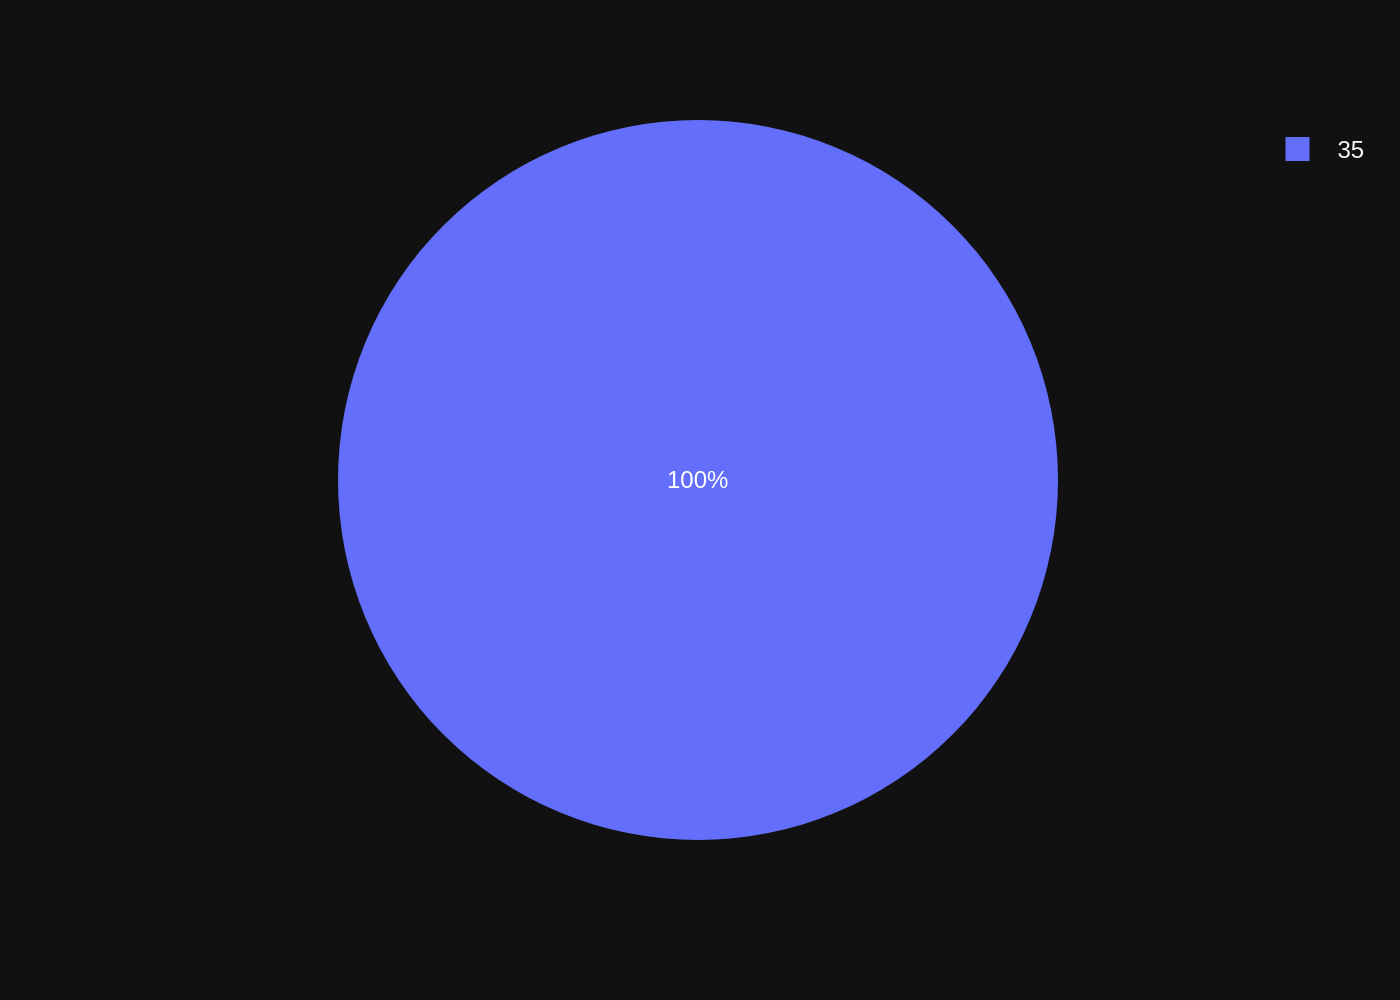

('select avg(age) from user',
   avg(age)
 0  35.0000,
 None)

In [15]:
vn.ask('用户的平均年龄')

In [16]:
result=vn.generate_sql('打算给一批员工送福报，把他们的名字过滤出来')

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


[{'role': 'system', 'content': 'You are a SQL expert. \n===Tables \nCREATE TABLE IF NOT EXISTS user (\n        id INT PRIMARY KEY COMMENT \'用户ID\' ,\n        name VARCHAR(100) COMMENT \'姓名\',\n        age INT COMMENT \'年龄\'\n    ) COMMENT \'用户信息表\';\n\n\n\n===Additional Context \n\n"福报"是指age>=35岁，也就是可以向社会输送的人才\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n3. If the provided context is insufficient, please explain why it can\'t be generated. \n4. Please use the most relevant table(s). \n5. If the question has been asked and answered before, please repeat the answer exactly as it was given before. \n'}, {'role': 'user', 'content'

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


[{'role': 'system', 'content': 'You are a SQL expert. \n===Tables \nCREATE TABLE IF NOT EXISTS user (\n        id INT PRIMARY KEY COMMENT \'用户ID\' ,\n        name VARCHAR(100) COMMENT \'姓名\',\n        age INT COMMENT \'年龄\'\n    ) COMMENT \'用户信息表\';\n\n\n\n===Additional Context \n\n"福报"是指age>=35岁，也就是可以向社会输送的人才\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n3. If the provided context is insufficient, please explain why it can\'t be generated. \n4. Please use the most relevant table(s). \n5. If the question has been asked and answered before, please repeat the answer exactly as it was given before. \n'}, {'role': 'user', 'content'

Insert of existing embedding ID: 54db6ffd-201b-59a2-8568-cd05d82db461-sql
Add of existing embedding ID: 54db6ffd-201b-59a2-8568-cd05d82db461-sql


select name from user where age >= 35
select name from user where age >= 35
  name
0  小悲剧


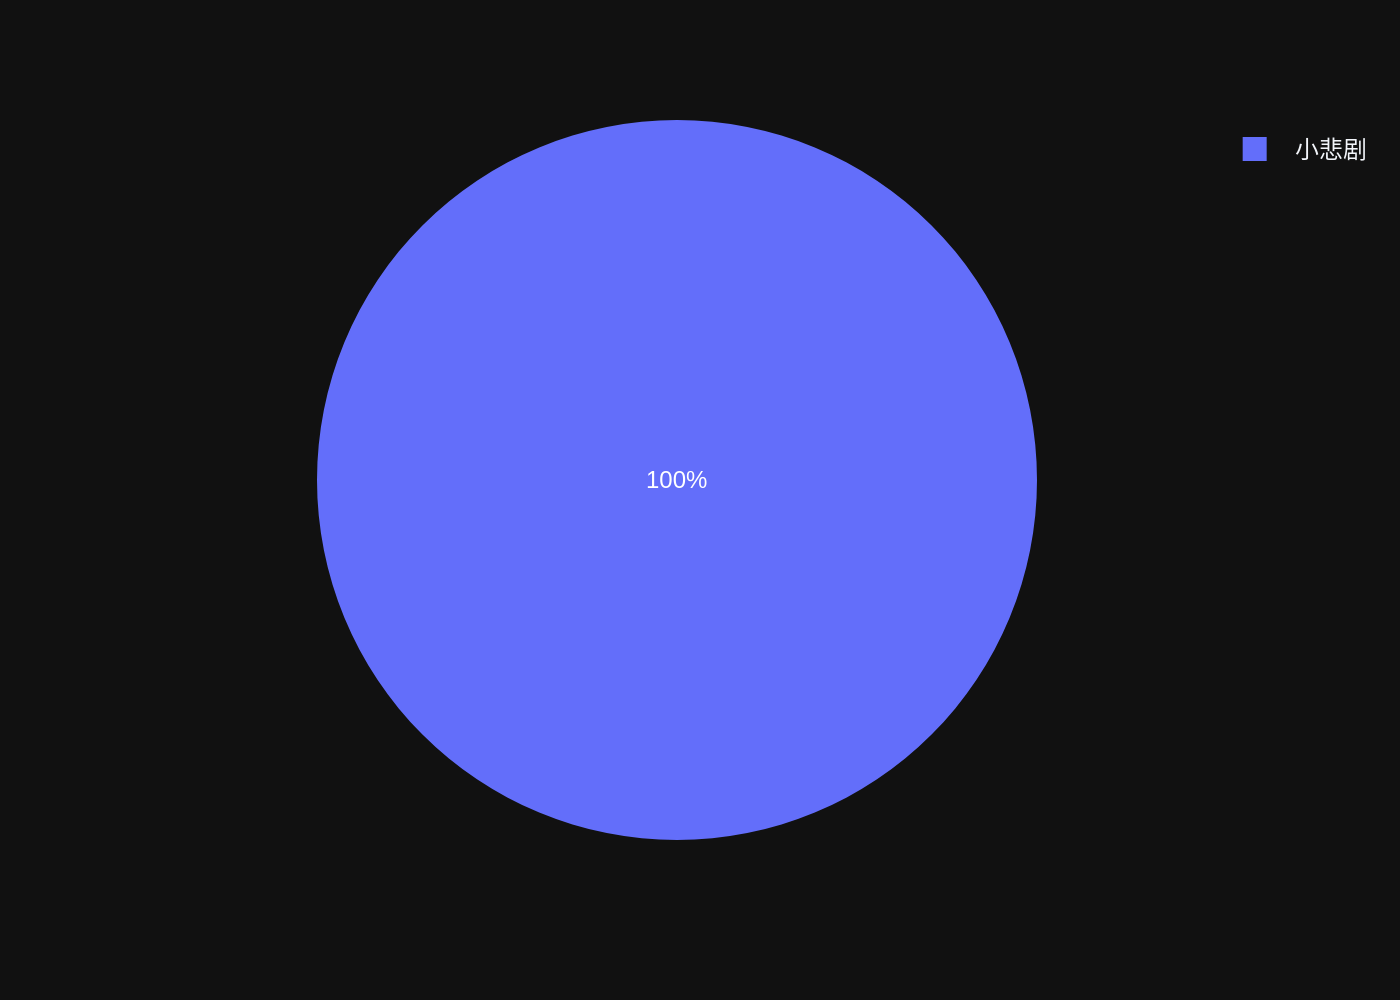

('select name from user where age >= 35',
   name
 0  小悲剧,
 None)

In [17]:
vn.ask('打算给一批员工送福报，把他们的名字过滤出来')

In [18]:
Q,A=DEBUG_INFO
print('PROMPT:',Q[0]['content'])
print('ANSWER:',A)

PROMPT: The following is a pandas DataFrame that contains the results of the query that answers the question the user asked: '打算给一批员工送福报，把他们的名字过滤出来'

The DataFrame was produced using this query: select name from user where age >= 35

The following is information about the resulting pandas DataFrame 'df': 
Running df.dtypes gives:
 name    object
dtype: object
ANSWER: ```python
import plotly.express as px

if len(df) == 1:
    fig = px.indicator(title='Employee Names', value=df['name'].iloc[0])
else:
    fig = px.bar(df, x='name', title='Employee Names')

fig.show()
```


In [19]:
vn.generate_sql('统计一下各年龄段的用户数量,年龄段是指0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80...左闭右开区间')

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


[{'role': 'system', 'content': 'You are a SQL expert. \n===Tables \nCREATE TABLE IF NOT EXISTS user (\n        id INT PRIMARY KEY COMMENT \'用户ID\' ,\n        name VARCHAR(100) COMMENT \'姓名\',\n        age INT COMMENT \'年龄\'\n    ) COMMENT \'用户信息表\';\n\n\n\n===Additional Context \n\n"福报"是指age>=35岁，也就是可以向社会输送的人才\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n3. If the provided context is insufficient, please explain why it can\'t be generated. \n4. Please use the most relevant table(s). \n5. If the question has been asked and answered before, please repeat the answer exactly as it was given before. \n'}, {'role': 'user', 'content'

"SELECT \n  CASE \n    WHEN age BETWEEN 0 AND 10 THEN '0-10'\n    WHEN age BETWEEN 11 AND 20 THEN '11-20'\n    WHEN age BETWEEN 21 AND 30 THEN '21-30'\n    WHEN age BETWEEN 31 AND 40 THEN '31-40'\n    WHEN age BETWEEN 41 AND 50 THEN '41-50'\n    WHEN age BETWEEN 51 AND 60 THEN '51-60'\n    WHEN age BETWEEN 61 AND 70 THEN '61-70'\n    WHEN age BETWEEN 71 AND 80 THEN '71-80'\n    ELSE '80+'\n  END AS age_group, COUNT(*) as user_count\nFROM user\nGROUP BY age_group;"

In [21]:
# 知识沉淀后可以直接提问
vn.train(documentation='用户年龄段划分逻辑：0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80...左闭右开区间')
vn.generate_sql('统计一下各年龄段的用户数量')

Insert of existing embedding ID: 82e9153e-0b3b-5aca-ac66-31e65eb61d36-doc
Add of existing embedding ID: 82e9153e-0b3b-5aca-ac66-31e65eb61d36-doc


Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2


Adding documentation....
[{'role': 'system', 'content': 'You are a SQL expert. \n===Tables \nCREATE TABLE IF NOT EXISTS user (\n        id INT PRIMARY KEY COMMENT \'用户ID\' ,\n        name VARCHAR(100) COMMENT \'姓名\',\n        age INT COMMENT \'年龄\'\n    ) COMMENT \'用户信息表\';\n\n\n\n===Additional Context \n\n用户年龄段划分逻辑：0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80...左闭右开区间\n\n"福报"是指age>=35岁，也就是可以向社会输送的人才\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n3. If the provided context is insufficient, please explain why it can\'t be generated. \n4. Please use the most relevant table(s). \n5. If the question has been asked and answered bef

"SELECT \n  CASE \n    WHEN age BETWEEN 0 AND 10 THEN '0-10'\n    WHEN age BETWEEN 11 AND 20 THEN '11-20'\n    WHEN age BETWEEN 21 AND 30 THEN '21-30'\n    WHEN age BETWEEN 31 AND 40 THEN '31-40'\n    WHEN age BETWEEN 41 AND 50 THEN '41-50'\n    WHEN age BETWEEN 51 AND 60 THEN '51-60'\n    WHEN age BETWEEN 61 AND 70 THEN '61-70'\n    WHEN age BETWEEN 71 AND 80 THEN '71-80'\n    ELSE '80+'\n  END AS age_group,\n  COUNT(*) as user_count\nFROM user\nGROUP BY age_group;"